# Beam stability checks

CCOB requirements state that the beam repeatability must be ensured at the 0.2% level. Two checks are performed below on CCOB data taken ETU1/2 on BOT:

1. Stability checked using average in a given amp over time
2. Sanity check performed using image differences

In [1]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import numpy as np
import yaml
import sys
sys.path.insert(0, '../')
import ccob_utils as u
from astropy.io import fits as fits
import pdb

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
config = u.load_ccob_config('../ccob_config_MR.yaml')

In [5]:
config['tmp_dir'] = '/home/combet/tmp_MR/stability'

### Make bias frames for R10,S11

In [97]:
#path_orig1='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6594D/BOT_acq/v0/45608/'
path_orig1b='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6695D/BOT_acq/v0/45615/'
#path_orig2='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6600D/BOT_acq/v0/45670/'
#path_orig3='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6603D/BOT_acq/v0/45698/'
#l1 = glob.glob(path_orig1+'/bias_bias_*/*R10*S11*')
l1b = glob.glob(path_orig1+'/bias_bias_*/*R10*S11*')
#l2 = glob.glob(path_orig2+'/bias_bias_*/*R10*S11*')
#l3 = glob.glob(path_orig3+'/bias_bias_*/*R10*S11*')


#u.make_superbias_frame(config, l1, 'R10', 'S11', file_pattern='_6594D_sbias_image.fits')
u.make_superbias_frame(config, l1b, 'R10', 'S11', file_pattern='_6595D_sbias_image.fits')
#u.make_superbias_frame(config, l2, 'R10', 'S11', file_pattern='_6600D_sbias_image.fits')
#u.make_superbias_frame(config, l3, 'R10', 'S11', file_pattern='_6603D_sbias_image.fits')

In [90]:
l2[1].split('/')[11]

'6600D'

In [92]:
led_names = ['uv', 'blue', 'red', 'nm750','nm850','nm960']

In [101]:
ref_flux_amp = {}
ref_flux_bunch = {}
ref_flux_amp_corr = {}
ref_flux_bunch_corr = {}
temp_led1 = {}  
temp_led2 = {} 
temp_sph = {}            
temp_brd = {} 
pd_val = {}

raft = 'R10'
slot = 'S11'
path_orig2='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6600D/BOT_acq/v0/45670/'
path_orig3='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6603D/BOT_acq/v0/45698/'

for led in led_names:
    path_orig1='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6594D/BOT_acq/v0/45608/'
    if (led=='uv' or led=='nm850'):
        path_orig1='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6595D/BOT_acq/v0/45615/'        
    ref_flux_amp[led] = []
    ref_flux_bunch[led] = []
    ref_flux_amp_corr[led] = []
    ref_flux_bunch_corr[led] = []
    pd_val[led] = []
    temp_led1[led] = []
    temp_led2[led] = []
    temp_sph[led] = []
    temp_brd[led] = []
    l1 = glob.glob(path_orig1+'/ccob_'+led+'*')
    l2 = glob.glob(path_orig2+'/ccob_'+led+'*')
    l3 = glob.glob(path_orig3+'/ccob_'+led+'*')
    l=l1+l2+l3
    print(led, len(l))
    flist = []
    for d in l:
        flist.append(glob.glob(d+'/*'+raft+'*'+slot+'*')[0])
    for f in flist:
        run = f.split('/')[11]
        if run=='6594D': biasfile = config['tmp_dir']+'/R10_S11_6594D_sbias_image.fits'
        if run=='6595D': biasfile = config['tmp_dir']+'/R10_S11_6595D_sbias_image.fits'
        if run=='6600D': biasfile = config['tmp_dir']+'/R10_S11_6600D_sbias_image.fits'
        if run=='6603D': biasfile = config['tmp_dir']+'/R10_S11_6603D_sbias_image.fits'
        bb = fits.open(f)
#        print(run, biasfile)
        pd = bb[0].header['CCOBADC']
#        pdb.set_trace()
        pd_val[led].append(pd)
        temp_led1[led].append(bb[0].header['TEMPLED1'])
        temp_led2[led].append(bb[0].header['TEMPLED2'])
        temp_sph[led].append(bb[0].header['TEMPSPH'])
        temp_brd[led].append(bb[0].header['TEMPBRD'])
        image = u.make_ccd_2d_array(f,biasfile=biasfile)
        ref_flux_amp[led].append(np.mean(image[0][0:2000,0:512])) # seg07 = amp8
        ref_flux_bunch[led].append(np.mean(image[0][985:1015,240:270]))
        ref_flux_amp_corr[led].append(np.mean(image[0][0:2000,0:512])/pd) # seg07 = amp8
        ref_flux_bunch_corr[led].append(np.mean(image[0][985:1015,240:270]/pd))
uber_dict = {'ref_flux_amp':ref_flux_amp, 
             'ref_flux_bunch':ref_flux_bunch, 
             'ref_flux_amp_corr':ref_flux_amp_corr, 
             'ref_flux_bunch_corr': ref_flux_bunch_corr,
             'pd_val':pd_val,
             'temp_led1':temp_led1, 
             'temp_led2':temp_led2, 
             'temp_sph':temp_sph, 
             'temp_bord':temp_brd}
with open(os.path.join(config['tmp_dir'],'stability_sbias.yml'), 'w') as outfile:
    yaml.dump(uber_dict, outfile)

uv 150
blue 150
red 150
nm750 134
nm850 150
nm960 150


In [102]:
d = yaml.load(open(os.path.join(config['tmp_dir'],'stability.yml')))
d2 = yaml.load(open(os.path.join(config['tmp_dir'],'stability_sbias.yml')))


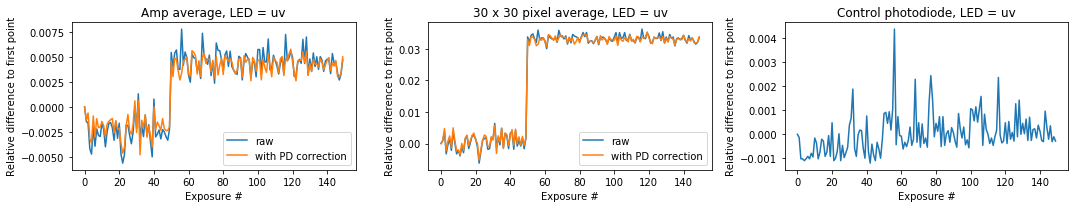

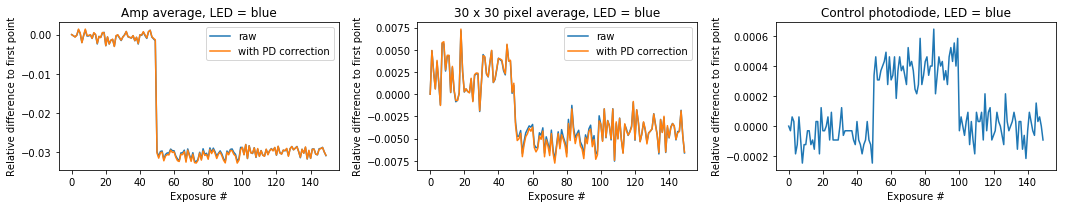

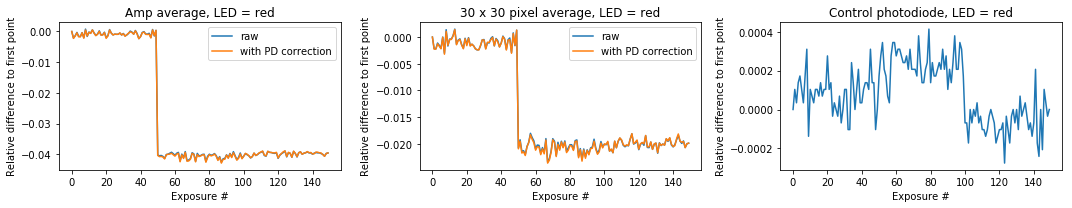

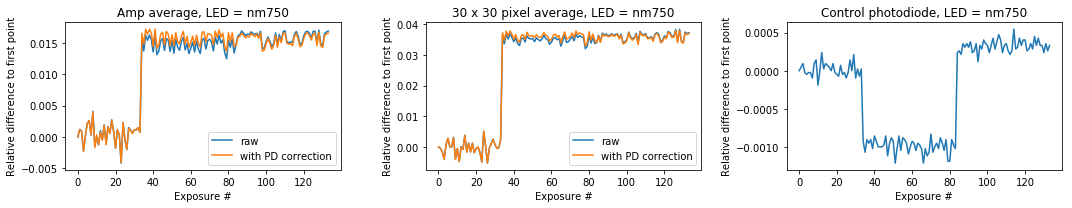

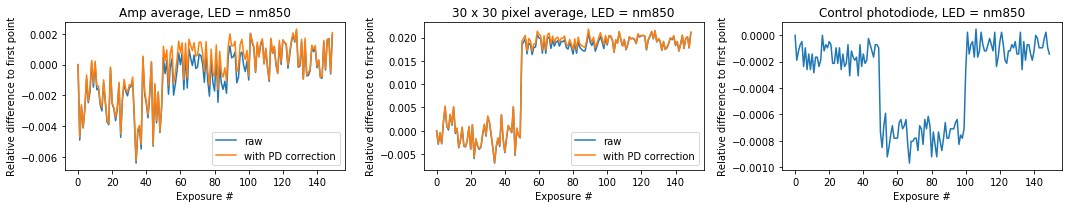

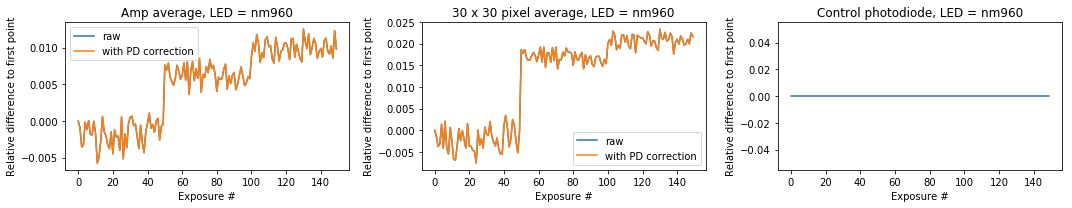

In [77]:
for led in led_names:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

    #     ax[0].plot((d['ref_flux_amp'][led]-np.mean(d['ref_flux_amp'][led]))/np.mean(d['ref_flux_amp'][led]), label='raw')
#     ax[0].plot((d['ref_flux_amp_corr'][led]-np.mean(d['ref_flux_amp_corr'][led]))/np.mean(d['ref_flux_amp_corr'][led]), label='with PD correction')
#     ax[0].set_ylabel('Relative difference to mean')
#     ax[0].set_xlabel('Exposure #')
#     #plt.ylim([-0.0025,0.0015])
#     ax[0].set_title('LED = '+led)
#     ax[0].legend()
    
#     ax[1].plot((d['ref_flux_bunch'][led]-np.mean(d['ref_flux_bunch'][led]))/np.mean(d['ref_flux_bunch'][led]), label='raw')
#     ax[1].plot((d['ref_flux_bunch_corr'][led]-np.mean(d['ref_flux_bunch_corr'][led]))/np.mean(d['ref_flux_bunch_corr'][led]), label='with PD correction')
#     ax[1].set_ylabel('Relative difference to mean')
#     ax[1].set_xlabel('Exposure #')
#     #plt.ylim([-0.0025,0.0015])
#     ax[1].set_title('LED = '+led)
#     ax[1].legend()

#     ax[2].plot((np.array(d['pd_val'][led])-np.mean(d['pd_val'][led]))/np.mean(d['pd_val'][led]), label='raw')
#     ax[2].set_title('LED = '+led)
#     fig.tight_layout()

    ax[0].plot((d['ref_flux_amp'][led]-(d['ref_flux_amp'][led][0]))/(d['ref_flux_amp'][led][0]), label='raw')
    ax[0].plot((d['ref_flux_amp_corr'][led]-(d['ref_flux_amp_corr'][led][0]))/(d['ref_flux_amp_corr'][led][0]), label='with PD correction')
    ax[0].set_ylabel('Relative difference to first point')
    ax[0].set_xlabel('Exposure #')
    #plt.ylim([-0.0025,0.0015])
    ax[0].set_title('Amp average, LED = '+led)
    ax[0].legend()
    
    ax[1].plot((d['ref_flux_bunch'][led]-(d['ref_flux_bunch'][led][0]))/(d['ref_flux_bunch'][led][0]), label='raw')
    ax[1].plot((d['ref_flux_bunch_corr'][led]-(d['ref_flux_bunch_corr'][led][0]))/(d['ref_flux_bunch_corr'][led][0]), label='with PD correction')
    ax[1].set_ylabel('Relative difference to first point')
    ax[1].set_xlabel('Exposure #')
    #plt.ylim([-0.0025,0.0015])
    ax[1].set_title('30 x 30 pixel average, LED = '+led)
    ax[1].legend()

    ax[2].plot((np.array(d['pd_val'][led])-(d['pd_val'][led][0]))/(d['pd_val'][led][0]), label='raw')
    ax[2].set_ylabel('Relative difference to first point')
    ax[2].set_xlabel('Exposure #')
    ax[2].set_title('Control photodiode, LED = '+led)
    fig.tight_layout()

    fig.savefig(config['tmp_dir']+'/'+led+'_stability_overview.png')



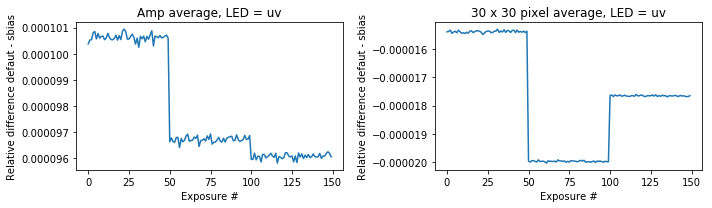

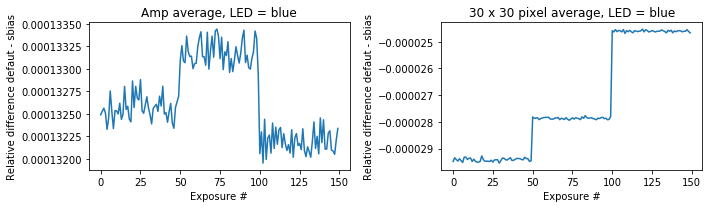

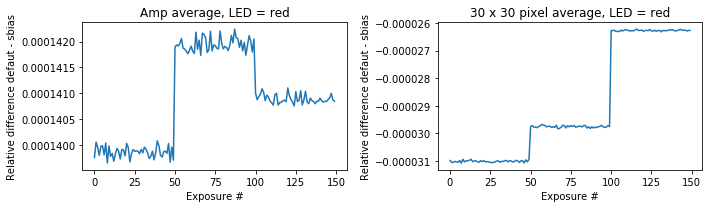

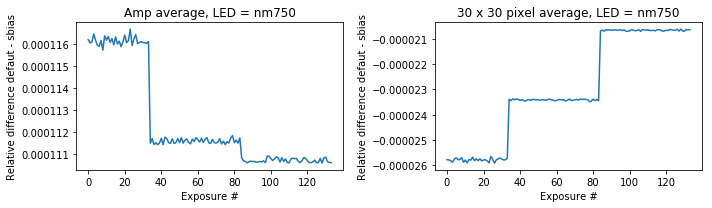

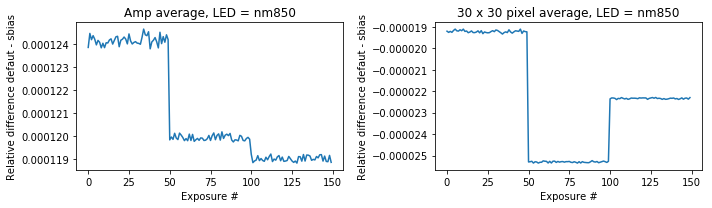

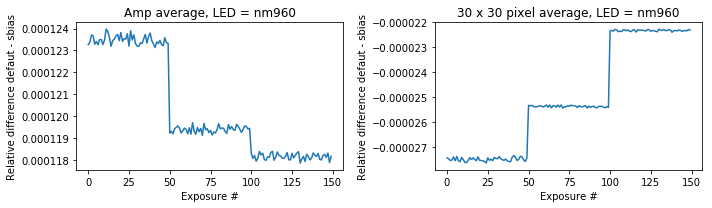

In [113]:
for led in led_names:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

    #     ax[0].plot((d['ref_flux_amp'][led]-np.mean(d['ref_flux_amp'][led]))/np.mean(d['ref_flux_amp'][led]), label='raw')
#     ax[0].plot((d['ref_flux_amp_corr'][led]-np.mean(d['ref_flux_amp_corr'][led]))/np.mean(d['ref_flux_amp_corr'][led]), label='with PD correction')
#     ax[0].set_ylabel('Relative difference to mean')
#     ax[0].set_xlabel('Exposure #')
#     #plt.ylim([-0.0025,0.0015])
#     ax[0].set_title('LED = '+led)
#     ax[0].legend()
    
#     ax[1].plot((d['ref_flux_bunch'][led]-np.mean(d['ref_flux_bunch'][led]))/np.mean(d['ref_flux_bunch'][led]), label='raw')
#     ax[1].plot((d['ref_flux_bunch_corr'][led]-np.mean(d['ref_flux_bunch_corr'][led]))/np.mean(d['ref_flux_bunch_corr'][led]), label='with PD correction')
#     ax[1].set_ylabel('Relative difference to mean')
#     ax[1].set_xlabel('Exposure #')
#     #plt.ylim([-0.0025,0.0015])
#     ax[1].set_title('LED = '+led)
#     ax[1].legend()

#     ax[2].plot((np.array(d['pd_val'][led])-np.mean(d['pd_val'][led]))/np.mean(d['pd_val'][led]), label='raw')
#     ax[2].set_title('LED = '+led)
#     fig.tight_layout()

    ax[0].plot((np.array(d['ref_flux_amp'][led])-np.array(d2['ref_flux_amp'][led]))/np.array(d['ref_flux_amp'][led]))
    ax[0].set_ylabel('Relative difference defaut - sbias')
    ax[0].set_xlabel('Exposure #')
    #plt.ylim([-0.0025,0.0015])
    ax[0].set_title('Amp average, LED = '+led)
    
    ax[1].plot((np.array(d['ref_flux_bunch'][led])-np.array(d2['ref_flux_bunch'][led]))/np.array(d['ref_flux_bunch'][led]))
    ax[1].set_ylabel('Relative difference defaut - sbias')
    ax[1].set_xlabel('Exposure #')
    #plt.ylim([-0.0025,0.0015])
    ax[1].set_title('30 x 30 pixel average, LED = '+led)
    fig.tight_layout()
    fig.savefig(config['tmp_dir']+'/'+led+'_stability_compare_bias.png')
    fig.savefig(config['tmp_dir']+'/'+led+'_stability_compare_bias.pdf')


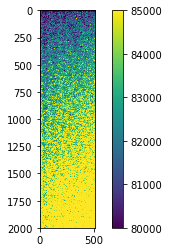

In [49]:
plt.imshow(image[0][0:2000,0:512], vmin=80000, vmax=85000)
plt.colorbar()

### Example of PD correction factor to apply to the data

In [9]:
pd, temp1, temp2, temp3, temp4, pos = ccob_properties(acq_log['uv'])
fact = ((np.array(pd) - pd[0])[0:10]/pd[0])  # S02
print fact
print 1./(1.+fact[7])/(1.+fact[0]) # correction factor to go from image 8 to image 1

[ 0.          0.00035442  0.00063615  0.00084062  0.00068613  0.00076338
  0.00074066  0.00066341  0.00086789  0.00068613]
0.99933702962


## 2. Stability check using image difference

10 images per sensor have been successively taken, with the CCOB in the same configuration. For a given sensor, the residuals between the 10 images should average to zero and be compatible with the expected noise level.

In [4]:
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft

In [5]:
def gains(eotest_results_file):
    """
    Extract Fe55 gains from the results file of some eo testing.
    """
    results = sensorTest.EOTestResults(eotest_results_file)
    return {amp: gain for amp, gain in zip(results['AMP'], results['GAIN'])}

def define_ccd_pos(ccd_pos_dict, raft_name, slot_names, xpos, ypos):
    ccd_pos_dict[raft_name] = {slot:[xpos[i],ypos[i]] for i,slot in enumerate(slot_names)}
    
def find_files(config, slot='*'):
    f_pattern = os.path.join(config['path'], slot+'*' + config['led_name'] + '*'
                             + config['current'] + '*' + config['exp_time'] + '*'
                             + config['xpos'] + '*' + config['ypos'] + '*')
    return glob.glob(f_pattern)
    

In [6]:
xpos = [253.0, 253.0, 253.0, 295.0, 295.0, 295.0, 337.0, 337.0, 337.0]
ypos = [237.0, 195.0, 153.0, 237.0, 195.0, 153.0, 237.0, 195.0, 153.0]
slot_names=['00','01','02','10','11','12','20','21','22']
ccd_pos_dict={}
define_ccd_pos(ccd_pos_dict, 'RTM-006', slot_names, xpos, ypos)

In [7]:
ccd_dict={}
gains_dict = {}
config = load_ccob_config('/home/combet/ccob-wb/ccob_config_RTM-006.yaml')
config['xpos'] = '*'
config['ypos'] = '*'
config['led_name'] = 'nm960'
config['path'] = os.path.join(config['path'],config['led_name'])
for slot in slot_names:
    f_list = []
    file_list=sorted(find_files(config,slot))
    xpos = str(ccd_pos_dict['RTM-006'][slot][0])
    ypos = str(ccd_pos_dict['RTM-006'][slot][1])
    pattern=slot+'_CCOB_'+config['led_name']+'_x'+xpos+'_y'+ypos
    for f in file_list:
        flag = pattern in f  
        if flag : f_list.append(f)
    ccd_dict[slot] = f_list    
    
    tmp = sensorTest.MaskedCCD(f_list[0])
    eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(tmp.md('LSST_NUM')))
    gains_dict[slot] = gains(eotest_results_file)   
    
print(ccd_dict['11'])


['/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215617.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215626.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215635.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215644.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215652.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215701.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215710.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/11_CCOB_nm960_x295.0_y195.0_0000_20180420215718.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM

### For each slot of the raft, performs the difference between the 1st and the 7th image centered on the slot

Histogram of the residuals are plotted for each slot and LED. 

In [8]:
template_image = os.path.join(config['tmp_dir'], '20_corr_mean_beam_image_RTM-006.fits')

slot_names=['00','01','02','10','11','12','20','21','22']
diff = {}
im_ref = {}
for slot in slot_names:
    diff[slot] = {}
    im_ref[slot] = {}
    image_ref = {}
    for i,f in enumerate([ccd_dict[slot][0],ccd_dict[slot][7]]):
        print(i, f)
        fname = os.path.basename(f)
        ccd_data = sensorTest.MaskedCCD(f)
        image = {}
        if i == 0:
            for amp in ccd_data:
                image_ref[amp] = ccd_data.unbiased_and_trimmed_image(amp)
                image_ref[amp] *= gains_dict[slot][amp]
                diff[slot][i] = image_ref[amp].getArrays()[0].flatten() if amp==1 else np.append(diff[slot][i],image_ref[amp].getArrays()[0].flatten())
        else:
            for amp in ccd_data:
                image[amp] = ccd_data.unbiased_and_trimmed_image(amp)
                image[amp] *= gains_dict[slot][amp]
#                image[amp] *= 0.997  # PD correction factor
                image[amp] -= image_ref[amp]
                diff[slot][i] = image[amp].getArrays()[0].flatten() if amp==1 else np.append(diff[slot][i],image[amp].getArrays()[0].flatten())


0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215245.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215346.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215104.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215207.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420214920.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420215021.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215756.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215900.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180

In [9]:
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

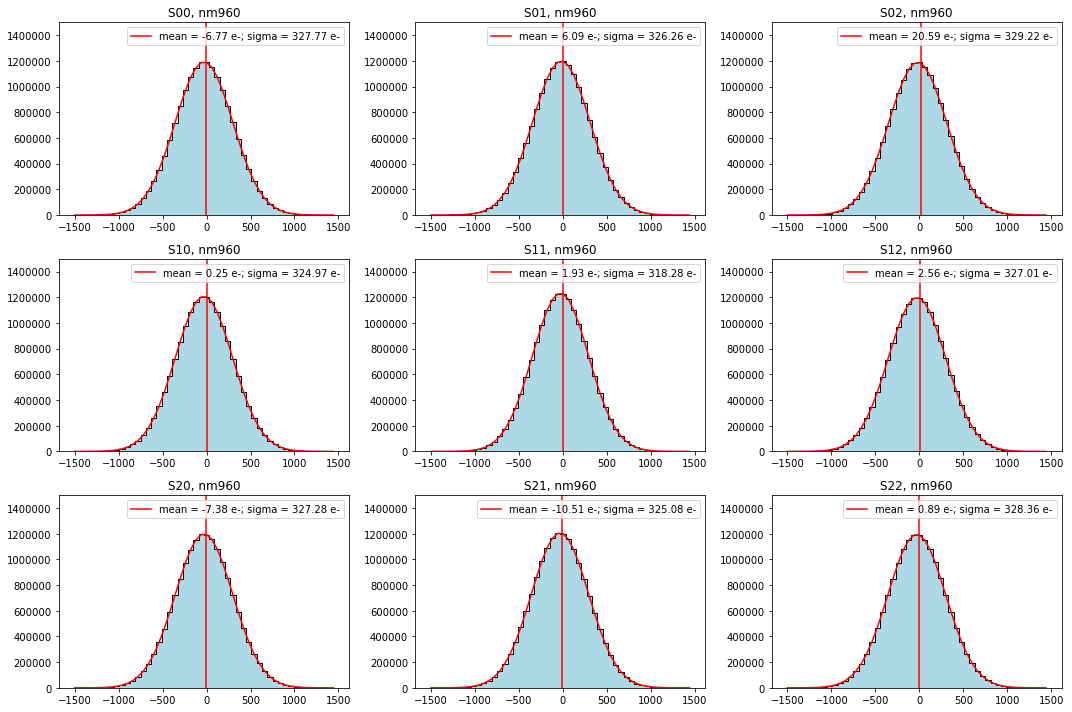

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
nbins = 50
for i,slot in enumerate(slot_names): 
    j,k = divmod(i,3)
    res = axes[j][k].hist(diff[slot][1], range=(-1500,1500), bins=nbins, align="left", edgecolor='black', color='lightblue',histtype= "stepfilled")
    popt,pcov = curve_fit(gaus,res[1][0:nbins],res[0])
#    label = "mean = "+"{:.2f}".format(popt[1])+ " e-; sigma = "+"{:.2f}".format(popt[2])+" e-"
    label = "mean = "+"{:.2f}".format(np.mean(diff[slot][1]))+ " e-; sigma = "+"{:.2f}".format(popt[2])+" e-"
    axes[j][k].plot(res[1][0:nbins],gaus(res[1][0:nbins], *popt), label=label, color='red')
#    axes[j][k].axvline(popt[1], color='r')    
    axes[j][k].axvline(np.mean(diff[slot][1]), color='r')    
    axes[j][k].set_ylim((0,1500000))
    axes[j][k].set_title("S"+slot+", "+config['led_name'])
    axes[j][k].legend()
fig.tight_layout()
fig.savefig(os.path.join(config['tmp_dir'],'CCOB_stability_img_diff2_'+config['led_name']+'.png'))

In [11]:
#template_image = os.path.join(config['tmp_dir'], '20_corr_mean_beam_image_RTM-006.fits')

slot_names=['00','01','02','10','11','12','20','21','22']
for slot in slot_names:
    image_ref = {}
    for i,f in enumerate([ccd_dict[slot][0],ccd_dict[slot][7]]):
        print(i, f)
        template_image = f
        fname = os.path.basename(f)
        ccd_data = sensorTest.MaskedCCD(f)
        image = {}
        if i == 0:
            for amp in ccd_data:
                image_ref[amp] = ccd_data.bias_subtracted_image(amp)
                image_ref[amp] *= gains_dict[slot][amp]
            imutils.writeFits({amp: image_ref[amp].getImage() for amp in ccd_data}, 
                      os.path.join(config['tmp_dir'],'image_ref_'+slot+'_'+config['led_name']+'.fits'), template_image)               
        else:
            for amp in ccd_data:
                image[amp] = ccd_data.bias_subtracted_image(amp)
                image[amp] *= gains_dict[slot][amp]
                image[amp] -= image_ref[amp]                       
            imutils.writeFits({amp: image[amp].getImage() for amp in ccd_data}, 
                      os.path.join(config['tmp_dir'],'image_diff_'+slot+'_'+config['led_name']+'.fits'), template_image)               

0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215245.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/00_CCOB_nm960_x253.0_y237.0_0000_20180420215346.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215104.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/01_CCOB_nm960_x253.0_y195.0_0000_20180420215207.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420214920.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/02_CCOB_nm960_x253.0_y153.0_0000_20180420215021.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215756.fits.fz
1 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/nm960/10_CCOB_nm960_x295.0_y237.0_0000_20180420215900.fits.fz
0 /gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180

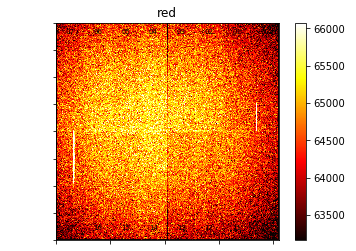

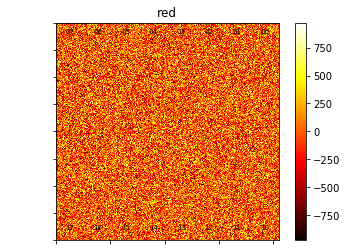

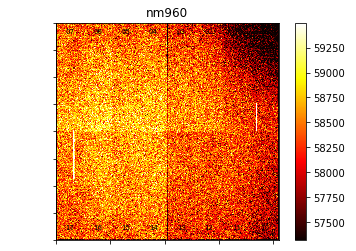

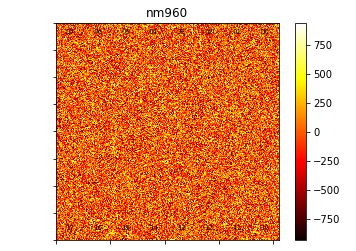

In [12]:
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_ref_11_red.fits'), title='red', nsig=2.5)
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_diff_11_red.fits'), title='red', nsig=3)

sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_ref_11_nm960.fits'), title='nm960', nsig=2.5)
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'image_diff_11_nm960.fits'), title='nm960', nsig=3)